<a href="https://colab.research.google.com/github/RATANAJANGIR/signboard-detection-and-translations/blob/main/text_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Loads the dataset and the pickle file generated from preprocessing and trains an encoder decoder model

In [ ]:
!pip install torch==1.6.0 torchvision==0.7.0

     |████████████████████████████████| 748.8MB 19kB/s 
     |████████████████████████████████| 5.9MB 30.4MB/s 
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.6.0 which is incompatible.
  Found existing installation: torch 1.8.1+cu101
    Uninstalling torch-1.8.1+cu101:
      Successfully uninstalled torch-1.8.1+cu101
  Found existing installation: torchvision 0.9.1+cu101
    Uninstalling torchvision-0.9.1+cu101:
      Successfully uninstalled torchvision-0.9.1+cu101


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Data Preprocessing**

In [ ]:
import unicodedata
import pandas as pd
from tqdm import tqdm

In [ ]:
# These ranges are in hexadecimal format
def _unicode_to_idx_map(lower_range, upper_range, start_index):
    l_range = int(lower_range, 16) 
    u_range = int(upper_range, 16)
    name2idx = dict()
    idx = start_index
    for char_code in range(l_range, u_range + 1):
        code_point = chr(char_code)
        char_name = unicodedata.name(code_point)
        name2idx[char_name] = idx
        idx = idx + 1
    return name2idx, idx 

In [ ]:
start_index = 3  ## Start from 3 as the first three inidices are reserved for <start> <stop> and <PAD> token
name2idx, idx = _unicode_to_idx_map("0900", "094D", start_index)
digits, idx = _unicode_to_idx_map("0966", "096F", idx)
om, idx = _unicode_to_idx_map("0950", "0950", idx)
additional, idx = _unicode_to_idx_map("0958", "095F", idx)

name2idx.update(digits)
name2idx.update(om)
name2idx.update(additional)

In [ ]:
def get_labels(text, name2idx):
    labels = list()
    for char in text:
        name = unicodedata.name(char)
        index = name2idx[name]
        labels.append(index)
    return labels

In [ ]:
annotation_file_loc = '/content/drive/MyDrive/EE626_Project/cropped_data/annotations.txt'
with open(annotation_file_loc) as fp:
    # find the max length of the data labels for padding
    labels = list()
    for line in fp.readlines():
        hindi_text = line.split('\t')[1].strip()
        try:
            labels.append(get_labels(hindi_text, name2idx))
        except KeyError:
            pass
    max_len = max([len(label) for label in labels]) + 2  # including start and stop symbols

In [ ]:
max_len

16

In [ ]:
cols = ['name', 'text', 'labels', 'unpadded_length']
annotation_df = pd.DataFrame()
with open(annotation_file_loc) as fp:
    data = {}
    for line in tqdm(fp.readlines()):
        img_path, hindi_text = line.split('\t')[:2]
        img_path = img_path.strip()
        hindi_text = hindi_text.strip()
        data['name'] = img_path
        data['text'] = f"<start> {hindi_text} <stop>"
        label = [0]  ## Initialize with the <start> token
        try:
            label.extend(get_labels(hindi_text, name2idx))
        except KeyError:
            continue
        label.append(1)  ## End with the <stop> token
        data['unpadded_length'] = int(len(label))
        extra_padding = max_len - len(label)
        label.extend([2] * extra_padding)
        data['labels'] = label
        annotation_df = annotation_df.append(data, ignore_index=True)

100%|██████████| 1740/1740 [00:05<00:00, 313.13it/s]


In [ ]:
print(annotation_df.head())
annotation_df.to_pickle('/content/drive/MyDrive/EE626_Project/cropped_data/annotation_cropped_preprocessed.pkl')

                                              labels  ... unpadded_length
0  [0, 31, 53, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2...  ...             4.0
1  [0, 57, 78, 42, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...  ...             5.0
2  [0, 43, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]  ...             3.0
3  [0, 59, 5, 50, 5, 39, 80, 51, 1, 2, 2, 2, 2, 2...  ...             9.0
4  [0, 47, 66, 43, 65, 1, 2, 2, 2, 2, 2, 2, 2, 2,...  ...             6.0

[5 rows x 4 columns]


In [ ]:
annotation_df.head()

,labels,name,text,unpadded_length
0,"[0, 31, 53, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2...",cropped_dir/0.jpg,<start> जल <stop>,4.0
1,"[0, 57, 78, 42, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",cropped_dir/1.jpg,<start> शोध <stop>,5.0
2,"[0, 43, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]",cropped_dir/2.jpg,<start> न <stop>,3.0
3,"[0, 59, 5, 50, 5, 39, 80, 51, 1, 2, 2, 2, 2, 2...",cropped_dir/3.jpg,<start> संयंत्र <stop>,9.0
4,"[0, 47, 66, 43, 65, 1, 2, 2, 2, 2, 2, 2, 2, 2,...",cropped_dir/4.jpg,<start> बिना <stop>,6.0


## Data loading

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

In [ ]:
random_state = 2021

In [ ]:
"""
The tokens <start> <stop> and <UNK> have the indices 0, 1, 2 respectively
"""
sos_id = 0
eos_id = 1
pad_id = 2
annotation_file_path = '/content/drive/MyDrive/EE626_Project/cropped_data/annotation_cropped_preprocessed.pkl'
img_loc = '/content/drive/MyDrive/EE626_Project/cropped_data/cropped_dir'

annotation_df = pd.read_pickle(annotation_file_path)
annotation_df.head()

,labels,name,text,unpadded_length
0,"[0, 31, 53, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2...",cropped_dir/0.jpg,<start> जल <stop>,4.0
1,"[0, 57, 78, 42, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",cropped_dir/1.jpg,<start> शोध <stop>,5.0
2,"[0, 43, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]",cropped_dir/2.jpg,<start> न <stop>,3.0
3,"[0, 59, 5, 50, 5, 39, 80, 51, 1, 2, 2, 2, 2, 2...",cropped_dir/3.jpg,<start> संयंत्र <stop>,9.0
4,"[0, 47, 66, 43, 65, 1, 2, 2, 2, 2, 2, 2, 2, 2,...",cropped_dir/4.jpg,<start> बिना <stop>,6.0


In [ ]:
# Train test split
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(annotation_df, test_size=0.10, random_state=random_state, shuffle=True)
train_df, val_df = train_test_split(train_df, test_size=0.05, random_state=random_state, shuffle=True)
print(train_df.shape)
print(val_df.shape)
print(test_df.shape)

(1487, 4)
(79, 4)
(174, 4)


## Create pytorch dataset

In [ ]:
from torch.utils.data import Dataset, DataLoader
import os
from PIL import Image
import cv2
from tqdm import tqdm

In [ ]:
class HindiText(Dataset):
    def __init__(self, base_dir, num_classes, transform=None, df=None, annotation_file_path=None):
        super().__init__()
        self.transform = transform
        if annotation_file_path is not None:
            annotation_ext = os.path.splitext(annotation_file_path)
            if annotation_ext is 'csv':
                self.annotation_df = pd.read_csv(annotation_file_path)
            elif annotation_ext is 'pkl':
                self.annotation_df = pd.read_pickle(annotation_file_path)
            else:
                raise ValueError('Only the (.csv, .pkl) extensions are supported')
        elif df is not None:
            self.annotation_df = df
        else:
            raise ValueError('Only one of `df` and `annotation_file_path` can be provided')

        self.images = []
        self.targets = []
        self.lengths = []

        for idx in tqdm(range(len(self.annotation_df))):
            obj = self.annotation_df.iloc[idx]
            img_path = os.path.join(base_dir, obj['name'])
            img = cv2.imread(img_path)
            try:
                img = Image.fromarray(img)
            except:
                continue
            self.images.append(img)
            self.targets.append(torch.as_tensor(obj['labels'], dtype=torch.int64))
            self.lengths.append(torch.as_tensor(obj['unpadded_length'], dtype=torch.int64))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        target = self.targets[idx]
        orig_length = self.lengths[idx]
        if self.transform:
            image = self.transform(image)
        return image, target, orig_length
        

In [ ]:
# Define the transforms for the train set
from torchvision import transforms

def get_transforms(train=False):
    T = list()
    if train:
        # Add more transforms here
        # T.append(transforms.RandomGrayscale(p=0.5))
        pass
    # T.append(transforms.Resize((224, 224)))  # Used for VGG
    T.append(transforms.Resize((299, 299)))  # Used for inception_v3
    T.append(transforms.ToTensor())
    return transforms.Compose(T)

In [ ]:
base_dir = '/content/drive/MyDrive/EE626_Project/cropped_data'
# base_dir = ""
num_classes = 100
train_dataset = HindiText(base_dir, num_classes, df=train_df, transform=get_transforms(train=True))
val_dataset = HindiText(base_dir, num_classes, df=val_df, transform=get_transforms())
test_dataset = HindiText(base_dir, num_classes, df=test_df, transform=get_transforms())

100%|██████████| 174/174 [00:46<00:00,  3.78it/s]


torch.Size([16])
tensor(12)


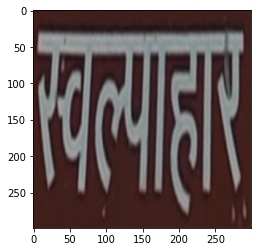

In [ ]:
# Sanity check the dataset creation
sample_image, sample_target, sample_length = train_dataset[0]
plt.imshow(sample_image.permute(1, 2, 0))
print(sample_target.shape)
print(sample_length)

## Define the encoder decoder model here

Using the encoder decoder implementation from the paper `Show and Tell` with a pretrained VGG-16 encoder and a untrained Bi-LSTM model in the decoder. Not using the attention model for generating the characters. The decoder is a character level RNN.

The Encoder is a VGG-11 model with batch normalization.

In [ ]:
import torchvision.models as models
import torch.nn as nn

In [ ]:
class Encoder(nn.Module):
    def __init__(self, output_size):
        super().__init__()
        # self.encoder = models.vgg16_bn(pretrained=True)
        self.encoder = models.inception_v3(pretrained=True, aux_logits=False)
        # self.encoder.classifier[6] = nn.Linear(in_features=4096, out_features=output_size, bias=False)
        self.encoder.fc = nn.Linear(in_features=2048, out_features=output_size, bias=False)

        # Freeze the model params except the classifier block of the network
        freeze_layer = 'Mixed_7c.branch_pool.conv.weight'
        # freeze_layer = 'Mixed_7a.branch3x3_1.conv.weight'
        for name, param in self.encoder.named_parameters():
            if name == freeze_layer:
                break
            param.requires_grad = False

    def forward(self, input):
        output = self.encoder(input)
        return output

In [ ]:
# Sanity check the model
print(len(train_dataset))
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
sample_batch, sample_labels, sample_lengths = next(iter(train_loader))
sample_batch = sample_batch.cuda()
sample_labels = sample_labels.cuda()
print(sample_batch.shape)
print(sample_labels.shape)

1487
torch.Size([32, 3, 299, 299])
torch.Size([32, 16])


In [ ]:
output_size = 512
encoder = Encoder(output_size).cuda()
sample_features = encoder(sample_batch)
print(sample_features.shape)

Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-1a9a5a14.pth



torch.Size([32, 512])


In [ ]:
# Define the Decoder
class Decoder(nn.Module):
    def __init__(self, hidden_size, output_size, pad_id, num_layers=1, dropout=0, bi=False):
        super().__init__()
        self.pad_id = pad_id
        self.embedding = nn.Embedding(output_size, hidden_size, padding_idx=self.pad_id)
        # self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers=num_layers, bias=False, batch_first=True, dropout=dropout, bidirectional=bi)
        self.gru = nn.GRU(hidden_size, hidden_size, num_layers=num_layers, bias=False, batch_first=True, dropout=dropout, bidirectional=bi)
        if bi is True:
            hidden_size = 2 * hidden_size
        self.linear = nn.Linear(hidden_size, output_size, bias=False)
        # Incoming dim would be (batch_size, seq_len, output_size)
        self.softmax = nn.LogSoftmax(dim=2)

    def forward(self, input, hidden_state, lengths):
        embedding = self.embedding(input)

        # Pack the padded embedding sequence
        packed_seq = nn.utils.rnn.pack_padded_sequence(embedding, lengths, batch_first=True, enforce_sorted=False)
        # output, (h_state, c_state) = self.lstm(packed_seq, hidden_state)
        output, h_state = self.gru(packed_seq, hidden_state)

        # Unpack the gru output
        output, _ = nn.utils.rnn.pad_packed_sequence(output, batch_first=True)
        output = self.linear(output)
        output = self.softmax(output)
        return output, h_state

In [ ]:
# Sanity check the decoder
input_size = 16
hidden_size = 512
output_size = 100

decoder = Decoder(hidden_size, output_size, pad_id).cuda()
# hidden_state = (sample_features.view(1, -1, hidden_size), torch.zeros(sample_features.view(1, -1, hidden_size).shape, device='cuda'))
hidden_state = sample_features.view(1, -1, hidden_size)
# decoder_output, (hn_state, cn_state) = decoder(sample_labels, hidden_state, sample_lengths)
decoder_output, hn_state = decoder(sample_labels, hidden_state, sample_lengths)
print(decoder_output.shape)

torch.Size([32, 12, 100])


## Model training

In [ ]:
num_epochs = 30
log_step = 20
batch_size = 32
num_workers = 4

# Encoder Model hyperparameters
enc_output_size = 1024
enc_learning_rate = 0.001

# Decoder Model hyperparameters
seq_size = 16  # Sequence length
hidden_size = enc_output_size  # Hidden layer size
output_size = 100  # Number of classes
dec_learning_rate = 0.001
bidirectional = False  # Whether to use bi-LSTM
dropout = 0.3
num_layers = 3  # Number of LSTM stacks per seq step
num_directions = 2 if bidirectional else 1

In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

In [ ]:
# Loss criteria
loss = nn.NLLLoss()

# Model and optimizer variables
encoder = Encoder(enc_output_size).cuda()
encoder_optim = torch.optim.Adam(encoder.parameters(), lr=enc_learning_rate)

decoder = Decoder(hidden_size, output_size, pad_id, num_layers=num_layers, dropout=dropout, bi=bidirectional).cuda()
decoder_optim = torch.optim.Adam(decoder.parameters(), lr=dec_learning_rate)

In [ ]:
# Load the pretrained model parameters
encoder.load_state_dict(torch.load('/content/drive/MyDrive/EE626_Project/Recognition_model/encoder_inceptionv3_1024.pt'))
decoder.load_state_dict(torch.load('/content/drive/MyDrive/EE626_Project/Recognition_model/decoder_unigru_drop0.3_3.pt'))

<All keys matched successfully>

In [ ]:
def preds(image, encoder, decoder, sos_token_id, eos_token_id):
    # Put the models in the evaluation mode
    max_seq_len = seq_size

    image = image.unsqueeze(0).cuda().type(torch.int64)

    with torch.no_grad():
        # get the encoder output or the context vector
        context = encoder(image)
        context = context.view(1, -1, enc_output_size)

        context = torch.cat([context] * (num_directions * num_layers) , dim=0)

        # get the decoder output (with teacher forcing!)
        # hidden_state = (context, torch.zeros(context.shape).cuda())
        hidden_state = context
        input = torch.as_tensor([[sos_token_id]], dtype=torch.int64).cuda()
        values = []
        indices = []
        for idx in range(max_seq_len):
            # decoder_output, (hn_state, cn_state) = decoder(input, hidden_state, torch.as_tensor([1], dtype=torch.long, device='cuda'))
            decoder_output, hn_state = decoder(input, hidden_state, torch.as_tensor([1], dtype=torch.int64, device='cuda'))
            # hidden_state = (hn_state, cn_state)
            hidden_state = hn_state
            preds = decoder_output.view(-1, output_size)
            preds = torch.topk(preds, 1)
            value, index = preds.values, preds.indices.item()
            values.extend(torch.exp(value))
            indices.append(index)
            input = preds.indices

            if index == eos_token_id:
                break
    return values, indices

In [ ]:
def train_one_epoch(loader, encoder, decoder, e_optim, d_optim, criterion, log_step=10):
    loss_profile = []
    eos_token = 1
    for step, (images, targets, lengths) in enumerate(loader):
        batch_size = lengths.size()[0]
        images = images.cuda()
        targets = targets.cuda()
        e_optim.zero_grad()
        d_optim.zero_grad()

        # get the encoder output or the context vector
        context = encoder(images)
        context = context.view(1, -1, enc_output_size)

        context = torch.cat([context] * (num_directions * num_layers) , dim=0)

        # get the decoder output (without teacher forcing!)
        # TODO: Experiment with a random state to switch between teacher forcing
        # and normal flow
        # hidden_state = (context, torch.zeros(context.shape).cuda())
        hidden_state = context
        loss = 0


        # decoder_output, (hn_state, cn_state) = decoder(targets, hidden_state, lengths)
        decoder_output, hn_state = decoder(targets, hidden_state, lengths)
        # print(decoder_output)
        max_seq_size = decoder_output.size()[1]
        loss_mask = torch.zeros(batch_size, max_seq_size, device='cuda')
        for idx in range(batch_size):
            length = lengths[idx].item()
            loss_mask[idx, :length] = 1

        for idx in range(max_seq_size - 1):
            mask = loss_mask[:, idx].view(-1, 1)
            output = decoder_output[:, idx, :]
            output = output * mask
            # print(targets[:, idx + 1])
            # print(torch.topk(output, 1).indices)
            
            loss += criterion(output, targets[:, idx + 1])

        # loss = loss / batch_size
        loss.backward()
        d_optim.step()
        e_optim.step()

        loss_profile.append(loss.item())

        if step % log_step == 0:
            # compute the evaluation loss
            # eval_loss = evaluate(val_loader, encoder, decoder, criterion)
            print(f"Training Loss: {loss.item()}")
        # break
    return loss_profile

In [ ]:
loss_profile = []
dec_lr_scheduler = torch.optim.lr_scheduler.StepLR(decoder_optim, step_size=10, gamma=0.1)
enc_lr_scheduler = torch.optim.lr_scheduler.StepLR(encoder_optim, step_size=10, gamma=0.1)

In [ ]:
encoder.train()
decoder.train()
for epoch_idx in range(num_epochs):
    print(f'Epoch: {epoch_idx + 1}')
    epoch_loss = train_one_epoch(train_loader, encoder, decoder, encoder_optim, decoder_optim, loss, log_step=log_step)
    loss_profile.extend(epoch_loss)
    dec_lr_scheduler.step()
    enc_lr_scheduler.step()
    # break

Epoch: 1
Training Loss: 1.165961742401123
Training Loss: 1.6319090127944946
Training Loss: 1.7382134199142456
Epoch: 2
Training Loss: 1.217682957649231
Training Loss: 1.1474782228469849
Training Loss: 2.8285984992980957
Epoch: 3
Training Loss: 1.4701014757156372
Training Loss: 1.6814664602279663
Training Loss: 1.2427998781204224
Epoch: 4
Training Loss: 1.4902067184448242
Training Loss: 1.5823545455932617
Training Loss: 1.4219359159469604
Epoch: 5
Training Loss: 1.469241738319397
Training Loss: 0.8787984848022461
Training Loss: 1.8438204526901245
Epoch: 6
Training Loss: 0.524832546710968
Training Loss: 1.0408580303192139
Training Loss: 1.756569743156433
Epoch: 7
Training Loss: 1.4108176231384277
Training Loss: 2.574817419052124
Training Loss: 1.346649169921875
Epoch: 8
Training Loss: 0.8994222283363342
Training Loss: 0.9755166172981262
Training Loss: 1.5925778150558472
Epoch: 9
Training Loss: 1.5128875970840454
Training Loss: 1.564520001411438
Training Loss: 1.716216802597046
Epoch: 10


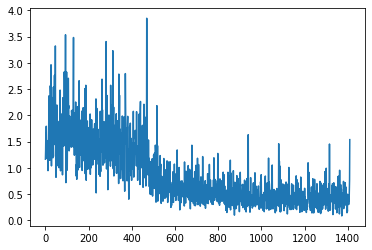

In [ ]:
plt.plot(loss_profile)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
device

device(type='cuda', index=0)

tensor([ 0, 45, 51, 66, 58, 41,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2])
[0.8210777044296265, 0.8238862752914429, 0.982929527759552, 0.9995454549789429, 0.9999961256980896, 0.9998351335525513, 0.9889869093894958]
[59, 80, 56, 29, 80, 30, 1]


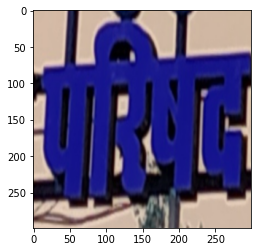

In [ ]:
# print(decoder)
encoder.eval()
decoder.eval()

image, target, _ = val_dataset[0]
plt.imshow(image.permute(1,2,0))
image=image.type(torch.int64)
print(target)

# get the predictions
values, indices = preds(image, encoder, decoder, 0, 1)
print([value.item() for value in values])
print(indices)

In [ ]:
print(indices)

[59, 80, 56, 29, 80, 30, 1]


In [ ]:
res =[]
for k,v in name2idx.items():
  for i in indices:
    if v == i:
      print(k)
      res.append(k)


DEVANAGARI LETTER CA
DEVANAGARI LETTER CHA
DEVANAGARI LETTER VA
DEVANAGARI LETTER SA
DEVANAGARI SIGN VIRAMA
DEVANAGARI SIGN VIRAMA


In [ ]:
str1=[]
for i in res:
  e = unicodedata.lookup(i)
  str1.append(e)
str1= ''.join([str(x) for x in str1])

In [ ]:
str1

'चछवस््'

In [ ]:
# Save the model state
# Path of the output file: `model_<architecture>_<dropout_rate>_<output_size>.pt`
encoder_path = f'/content/drive/MyDrive/EE626_Project/Recognition_model/encoder_inceptionv3_{enc_output_size}.pt'
decoder_path = f'/content/drive/MyDrive/EE626_Project/Recognition_model/decoder_unigru_drop{dropout}_{num_layers}.pt'
torch.save(encoder.state_dict(), encoder_path)
torch.save(decoder.state_dict(), decoder_path)

In [ ]:
# data = torch.load("/content/drive/MyDrive/EE626_Project/cropped_data/dataset")
# val_set = data["val"]

In [ ]:
import torch
encoder_model = torch.load("/content/drive/MyDrive/EE626_Project/cropped_data/encoder_inceptionv3_1024.pt")
decoder_model = torch.load("/content/drive/MyDrive/EE626_Project/cropped_data/decoder_unigru_drop0.3_3.pt")

In [ ]:
inception = models.inception_v3(pretrained=True)
[name for name, _ in inception.named_parameters()]